# CNN Fashion MNIST


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Lorenzo-Giardi/tf-keras/blob/master/5_CNN/cnn_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
# use in colab
# %tensorflow_version 2.x

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, AveragePooling2D

np.random.seed(42)
tf.random.set_seed(42)

## Data
We use the usual Fashion MNIST dataset and images are standardized. Notice that they could be simply rescaled dividing by 255.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

Convolutional 2D layers expect the single input data to be 3D, with dimensions [height, width, channels], however Fashion MNIST images are grey-scale, thus they do not have a channel axis. We can directly add it to the data using np.newaxis or we can begin the network with a reshape layer. Notice that while the single image should be 3D, a minibatch of multiple images will be a 4D tensor with dimensions [batch_size, height, width, channels].

In [4]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f'Training set shape: {X_train.shape}')

Training set shape: (55000, 28, 28, 1)


In [5]:
labels = ['T-shirt', 'Troursers', 'Pullover', 'Dress', 'Coat', 'Sandal',
              'Shirt', 'Sneaker', 'Bag', 'Ankle_boot']

## Convolutional layers
When dealing with images, convolutional layers generally outperform fully connected one because they are better at recognizing small patterns, like lines and circles. The core idea is that of a **receptive field**: while neurons in a FC layers are connected with every neuron in the preceeding layer, neurons in a convolutional layer are only connected to a local subset of neurons in the preceeding layer. \
The width and heigh of this receptive field is determined by the kernel_size parameter. Then, this kind of filter will be swept all over the image according to the stride parameter, which determines the filter's movement in each direction. Near the edges there could be a mismatch between the filter and the image, which can be either solved by discarding these corner pixels (padding = 'valid', aka no-padding) or by zero-padding wherever needed (padding = 'same').  \
A filter will output a **feature map**, i.e. a new image that highlights certain features of the original image (e.g. horizontal lines). Each convolutional layer combines multiple filters, which will thus produce multiple feature maps as their outputs. These are stacked together exactly like RGB channels in a colour image. Thus, convolutional layers effectively increase the depth of the images!

In [6]:
Conv2D(filters = 64, # number of filters, determines depth of output
       kernel_size = (3,3), # could be a single integer
       strides = (1,1), # could be a single integer
       activation='relu', 
       padding = 'same' # same or valid
      )

## Pooling layers
Since convolutional layers increase the depth of images, we need to **downscale** their resolution (i.e. their height and width) in order to keep the data size manageable. This is done through pooling layers, which perform a **local aggregation** by taking the mean or max value in a certain area of the image or feature map. 

In [7]:
MaxPooling2D(pool_size=(2,2), # halve size in each dimension, hence resolution is 1/4
             strides=None, # automatically equal to pooling size
             padding = 'valid'
            )

In [8]:
AveragePooling2D(pool_size=(2,2), # halve size in each dimension, hence resolution is 1/4
             strides=None, # automatically equal to pooling size
             padding = 'valid'
            )

## Convolutional Network

In [9]:
model = Sequential([
    Conv2D(64, 7, activation='relu', padding = 'same', input_shape = [28, 28, 1]),
    MaxPooling2D(2),
    Conv2D(128, 3, activation='relu', padding = 'same'),
    MaxPooling2D(2),
    Conv2D(256, 3, activation='relu', padding = 'same'),
    MaxPooling2D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

In [11]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights= True)

In [12]:
history = model.fit(X_train, y_train, epochs = 10, 
                    validation_data = (X_valid, y_valid),
                    callbacks=[earlystop_cb]
                   )

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 147s 3ms/sample - loss: 0.6002 - accuracy: 0.7888 - val_loss: 0.3397 - val_accuracy: 0.8762
Epoch 2/10
55000/55000 [==============================] - 151s 3ms/sample - loss: 0.3702 - accuracy: 0.8713 - val_loss: 0.3091 - val_accuracy: 0.8888
Epoch 3/10
55000/55000 [==============================] - 145s 3ms/sample - loss: 0.3148 - accuracy: 0.8919 - val_loss: 0.2931 - val_accuracy: 0.8900
Epoch 4/10
55000/55000 [==============================] - 142s 3ms/sample - loss: 0.2804 - accuracy: 0.9009 - val_loss: 0.2857 - val_accuracy: 0.8982
Epoch 5/10
55000/55000 [==============================] - 143s 3ms/sample - loss: 0.2579 - accuracy: 0.9101 - val_loss: 0.2851 - val_accuracy: 0.8990
Epoch 6/10
55000/55000 [==============================] - 158s 3ms/sample - loss: 0.2377 - accuracy: 0.9163 - val_loss: 0.2513 - val_accuracy: 0.9064
Epoch 7/10
55000/55000 [===========================

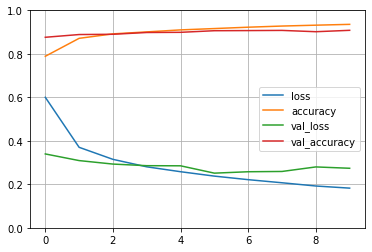

In [13]:
pd.DataFrame(history.history).plot(figsize = (6,4))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [14]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 7s 699us/sample - loss: 0.2837 - accuracy: 0.9059


[0.2837317298173904, 0.9059]

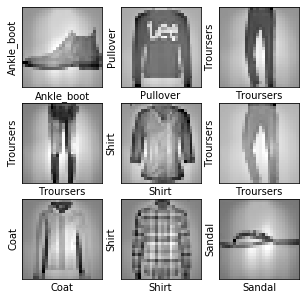

In [20]:
y_proba = model.predict(X_test[:9])
y_preds = model.predict_classes(X_test[:9])

# plot actual vs predicted classes
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test.squeeze()[i], cmap=plt.cm.binary)
    plt.ylabel(labels[y_test[i]])
    plt.xlabel(labels[y_preds[i]])
plt.show()